In [331]:
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import random
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import pickle
import tqdm

from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple
from itertools import count
import operator

import cProfile
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
#rc('font',**{'family':'sans-serif'})
#rc('text', usetex=True)
#rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
#rc('text.latex',preamble=r'\usepackage[russian]{babel}')
rc('figure', **{'dpi': 300})



In [332]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

In [333]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
#             print((i,j))
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -100, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1
        
def simulate_step(env_input, action):
    env = copy.deepcopy(env_input) 
    env.step(action)
    return env


In [334]:
class Strategy:
    def __init__(self, env, name, isRandom=False):
        self.Q = {}
        self.env = env
        self.history = []
        self.isRandom = isRandom
        self.INITIAL_VALUE = 0.6
        self.eps = 0.1
        self.gamma = 0.99
        self.alpha = 0.1
        self.name = name
        return
    
    def get_Q(self, state):
        if state not in self.Q:
            actions = self.env.getEmptySpaces()
            self.Q[state] = [self.INITIAL_VALUE for i,a in enumerate(actions)]   
        
        return self.Q[state]

    def getActionGreedy(self, state):
        q_vals = self.get_Q(state)
        max_q = max(q_vals)
        action_id = random.choice([i for i,q in enumerate(q_vals) if q == max_q])
        self.history.append((state, action_id))
        return action_id
    
    def get_action_index(self, state, n):
        sample = np.random.random()
        if sample > self.eps:
            return self.getActionGreedy(state)
        return np.random.randint(n) 
    
    def reset(self):
        self.history = []
        
    def update(self, reward):
        self.history.reverse()
        first = True
        for h in self.history:
            s = h[0]
            a = h[1]
            if first:
                self.Q[s][a] = reward
                first = False
            else:
                self.Q[s][a] = self.Q[s][a] + self.alpha * (reward + self.gamma * maxQ - self.Q[s][a])
            
            maxQ = np.max(self.Q[s])
        

In [335]:
from abc import ABCMeta, abstractmethod
class Policy(object):
    __metaclass__ = ABCMeta

    @abstractmethod
    def move(self, state):
        pass
    
    @abstractmethod
    def reset(self):
        pass
    
class RandomPolicy(Policy):
    def move(self, env):
        actions = env.getEmptySpaces()
        a = np.random.randint(len(actions))
        return actions[a]
    
    def reset(self):
        return

In [347]:
def continue_game(env, pi1, pi2):
    done = env.isTerminal() is not None
    reward = 0
    while not done:
        if env.curTurn == 1:
            action = pi1.move(env)
        else:
            action = pi2.move(env)
        observation, reward, done, info = env.step(action)
    
    return reward

def play_game(env, pi1, pi2):
    done = False
    env.reset()
    pi1.reset()
    pi2.reset()
    reward = 0
    while not done:
        if env.curTurn == 1:
            action = pi1.move(env)
        else:
            action = pi2.move(env)
        observation, reward, done, info = env.step(action)
    
    return observation, reward


def train(env, pi1, pi2, batch_size):
    pi1_wins = 0
    draws = 0
    pi2_wins = 0
    for i in range(batch_size):
        observation, reward = play_game(env, pi1, pi2)
        if reward == 1:
            pi1_wins += 1
        elif reward == -1:
            pi2_wins += 1
        else:
            draws += 1
            
        pi1.reset()
        pi2.reset()
        #env.reset()
        
    return (pi1_wins, draws, pi2_wins)

def train_and_plot_games( pi1, pi2, episodes=500):
    x_wins = []
    draws = []
    y_wins = []
    count = []
    batch = 100
    for i in tqdm.tqdm(range (episodes)):
        res = train(env, pi1, pi2, batch)
        x_wins.append(res[0] / batch)
        draws.append(res[1] / batch)
        y_wins.append(res[2] / batch)
        count.append(batch * i)
        
    plt.ylabel('Доля событий')
    plt.xlabel('Число игр')

    plt.plot(count, x_wins, 'b-', label='Крестики выиграли')
    plt.plot(count, y_wins, 'r-', label='Нолики выиграли')
    plt.plot(count, draws, 'g-', label='Ничья')
    plt.legend(loc='best')
    plt.show()

In [348]:
Random_x = RandomPolicy()
Random_y = RandomPolicy()

In [349]:
import networkx as nx
import copy

In [350]:
class MCTSPolicy(Policy):
    def __init__(self, env, player):
        self.env = env
        self.digraph = nx.DiGraph()
        self.player = player
        self.num_rollouts = 0
        self.uct_c = np.sqrt(2)
        self.node_counter = 0

        self.digraph.add_node(self.node_counter, attr_dict={'w': 0,
                                                            'n': 0,
                                                            'uct': 0,
                                                            'expanded': False,
                                                            'state': env})
        empty_board_node_id = self.node_counter
        self.node_counter += 1

        self.last_move = None

        if player == -1:
            for action in actions:
                next_env = simulate_step(env, action)
                self.digraph.add_node(self.node_counter, attr_dict={'w': 0,
                                                                    'n': 0,
                                                                    'uct': 0,
                                                                    'expanded': False,
                                                                    'state': next_env})
                
                self.digraph.add_edge(empty_board_node_id, self.node_counter)
                self.node_counter += 1
    
    def reset(self):
        self.last_move = None
    
    def move(self, starting_state_input):

        starting_state = copy.deepcopy(starting_state_input)
        starting_node = None

        if self.last_move is not None:
            exists = False
            for child in self.digraph.successors(self.last_move):
                if self.digraph.node[child]['attr_dict']['state'].getHash() == starting_state.getHash():
                    if self.digraph.has_edge(self.last_move, child):
                        exists = True
                        starting_node = child
            if not exists:
                self.digraph.add_node(self.node_counter,
                                      attr_dict={'w': 0,
                                                 'n': 0,
                                                 'uct': 0,
                                                 'expanded': False,
                                                 'state': starting_state})
                self.digraph.add_edge(self.last_move,
                                      self.node_counter)
                starting_node = self.node_counter
                self.node_counter += 1
        else:
            for node in self.digraph.nodes():
                if self.digraph.node[node]['attr_dict']['state'].getHash() == starting_state.getHash() :
                    starting_node = node

        max_rollouts = 25
        for i in range(max_rollouts):
            self.num_rollouts += 1
            selected_node = self.selection(starting_node)
            
            if self.digraph.node[selected_node]['attr_dict']['state'].gameOver:
                break

            new_child_node = self.expansion(selected_node)
            reward = self.rollout(new_child_node)
            self.backpropagation(new_child_node, reward)

        move, resulting_node = self.best_action(starting_node)
        self.last_move = resulting_node
        
        if self.digraph.node[resulting_node]['attr_dict']['state'].gameOver:
            self.last_move = None

        return move
    
    
    def best_action(self, root):

        children = self.digraph.successors(root)

        uct_values = {}
        for child_node in children:
            uct_values[child_node] = self.uct(child_node)

        best_children = [key for key, val in uct_values.items() if val == max(uct_values.values())]
        idx = np.random.randint(len(best_children))
        best_child = best_children[idx]

        action = self.digraph.get_edge_data(root, best_child)['attr_dict']['action']
        return action, best_child
    
    def selection(self, root):
        if root not in self.digraph.nodes():
            self.digraph.add_node(self.node_counter,
                                  attr_dict={'w': 0,
                                             'n': 0,
                                             'uct': 0,
                                             'expanded': False,
                                             'state': root})
            self.node_counter += 1
            return root
        elif not self.digraph.node[root]['attr_dict']['expanded']:
            return root  
        else:
            children = self.digraph.successors(root)
            uct_values = {}
            for child_node in children:
                uct_values[child_node] = self.uct(state=child_node)

            best_child_node = max(uct_values.items(), key=operator.itemgetter(1))[0]

            return self.selection(best_child_node)
        
    def expansion(self, node):
        children = self.digraph.successors(node)
        state = self.digraph.node[node]['attr_dict']['state']
        actions = state.getEmptySpaces()

        unvisited_children = []
        corresponding_actions = []
        
        for move in actions:
            child = simulate_step(state, move)

            in_children = False
            for child_node in children:
                if self.digraph.node[child_node]['attr_dict']['state'].getHash()  == child.getHash():
                    in_children = True

            if not in_children:
                unvisited_children.append(child)
                corresponding_actions.append(move)

        if len(unvisited_children) > 0:
            idx = np.random.randint(len(unvisited_children))
            child, move = unvisited_children[idx], corresponding_actions[idx]

            self.digraph.add_node(self.node_counter,
                                  attr_dict={'w': 0,
                                             'n': 0,
                                             'uct': 0,
                                             'expanded': False,
                                             'state': child})
            self.digraph.add_edge(node, self.node_counter, attr_dict={'action': move})
            child_node_id = self.node_counter
            self.node_counter += 1
        else:
            return node

        if len(list(children)) + 1 == len(actions):
            self.digraph.node[node]['attr_dict']['expanded'] = True

        return child_node_id
    
    def rollout(self, node):
        node_env = self.digraph.node[node]['attr_dict']['state']
        env = copy.deepcopy(node_env)
        reward = continue_game(env, Random_x, Random_y)
        if reward == self.player:
            return 1
        else:
            return 0
    
    def backpropagation(self, last_visited, reward):
        current = last_visited
        while True:
            self.digraph.node[current]['attr_dict']['n'] += 1
            self.digraph.node[current]['attr_dict']['w'] += reward

            if self.digraph.node[current]['attr_dict']['state'].getHash() == self.env.getHash():
                break

            try:
                current = list(self.digraph.predecessors(current))[0]
            except IndexError:
                break
                

    def uct(self, state):

        n = self.digraph.node[state]['attr_dict']['n'] 
        w = self.digraph.node[state]['attr_dict']['w']
        t = self.num_rollouts
        c = self.uct_c
        epsilon = 1e-6

        exploitation_value = w / (n + epsilon)
        exploration_value = c * np.sqrt(np.log(t) / (n + epsilon))

        value = exploitation_value + exploration_value

        self.digraph.node[state]['attr_dict']['uct'] = value

        return value

In [351]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
MCTS_x = MCTSPolicy(env, player=1)

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [17:18<00:00, 207.61s/it]


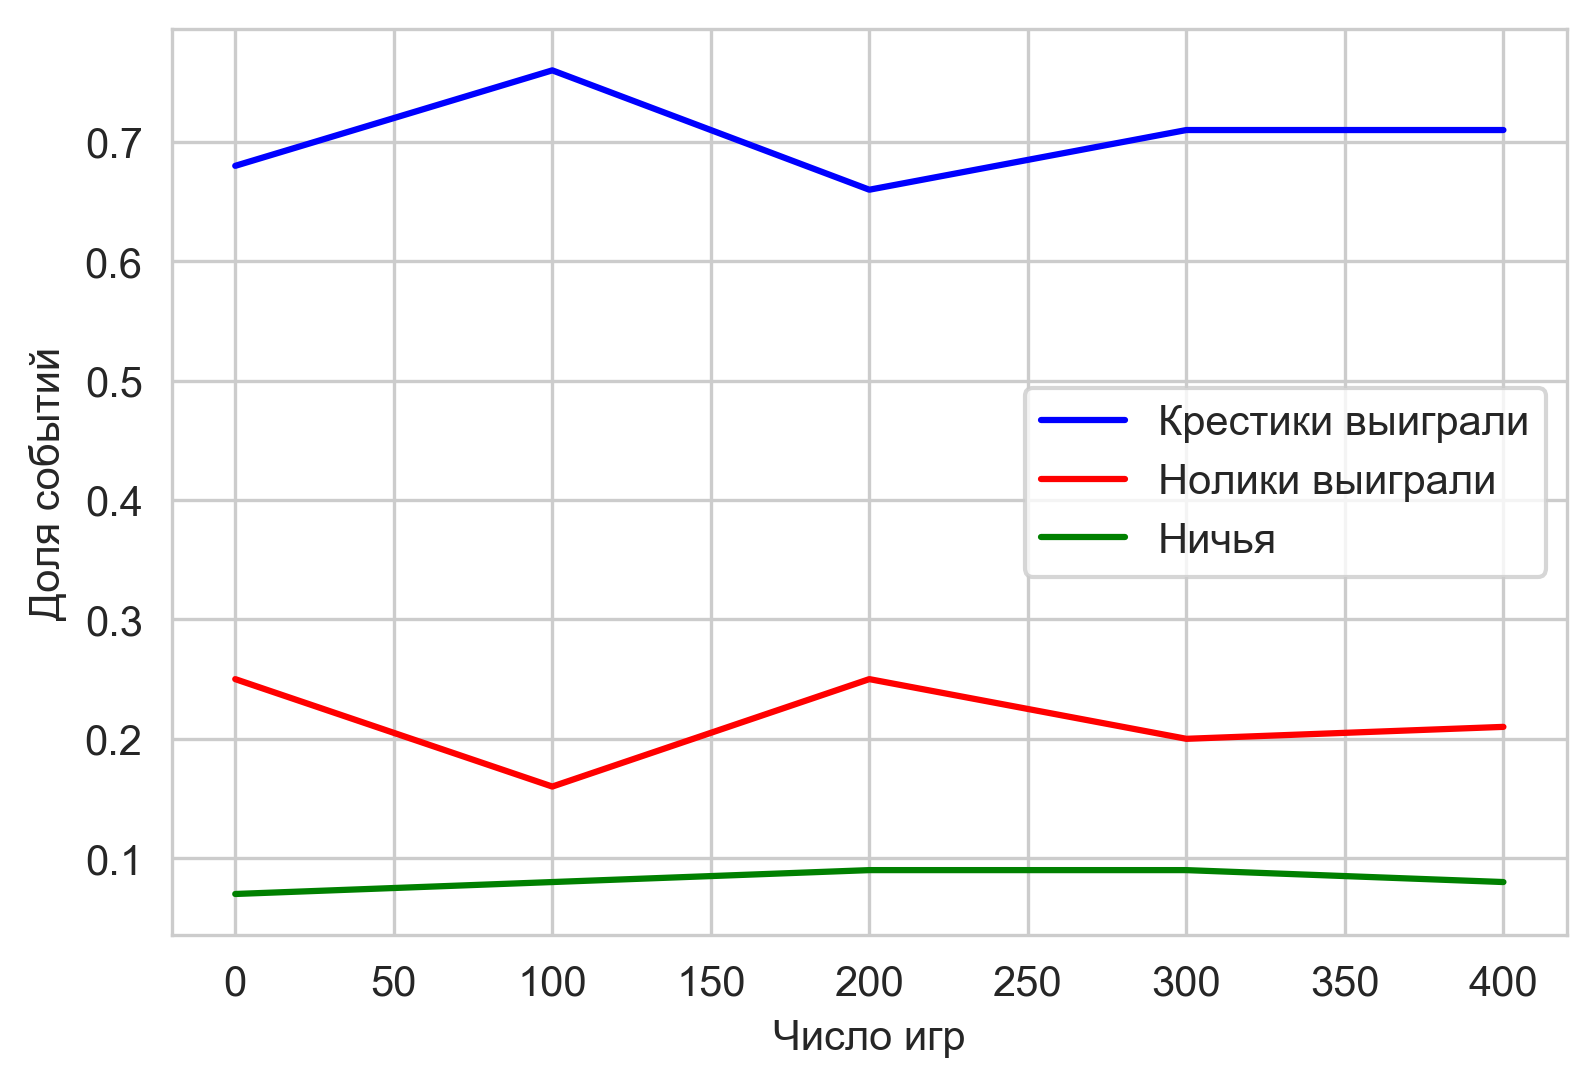

In [352]:
train_and_plot_games(MCTS_x, Random_y, 5)